In [24]:
import numpy as np
import argparse
from sklearn.model_selection import train_test_split
# import the Libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torch.autograd import variable

# Data Load and adjustment


In [25]:
# import the dataset
movies = pd.read_csv('/content/movies.dat', sep='::', header = None, engine='python', encoding='latin-1')
users = pd.read_csv('/content/users.dat', sep='::', header = None, engine='python', encoding='latin-1')
ratings = pd.read_csv('/content/ratings.dat', sep='::', header = None, engine='python', encoding='latin-1')

In [28]:
import missingno as mn

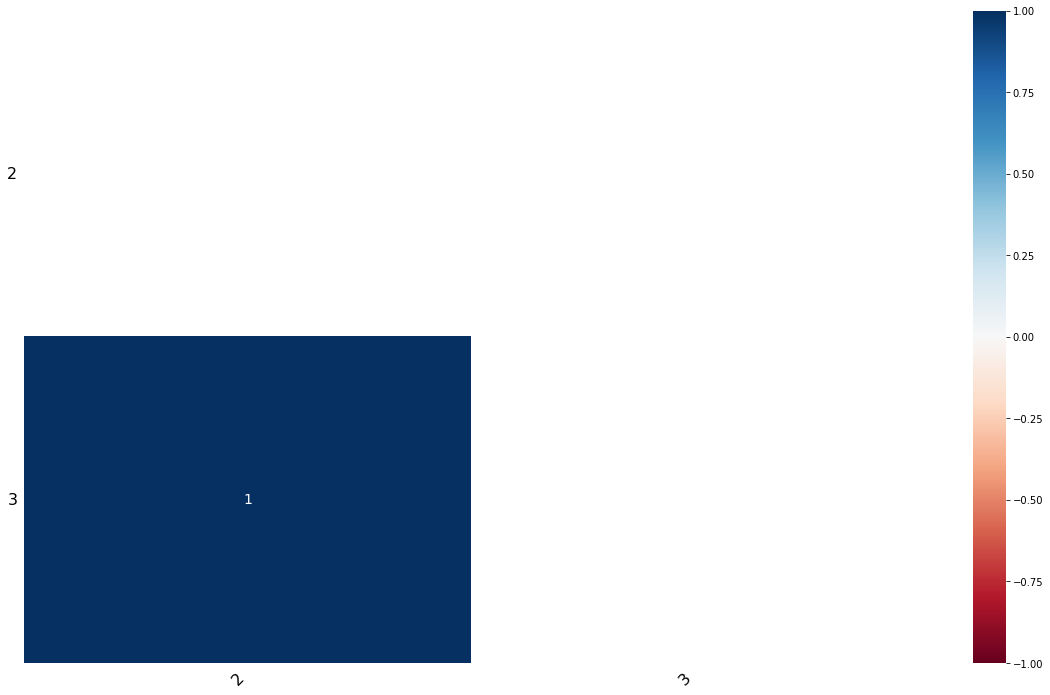

In [29]:
mn.heatmap(ratings)

/usr/local/lib/python3.7/dist-packages/seaborn/matrix.py:305: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
/usr/local/lib/python3.7/dist-packages/seaborn/matrix.py:305: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


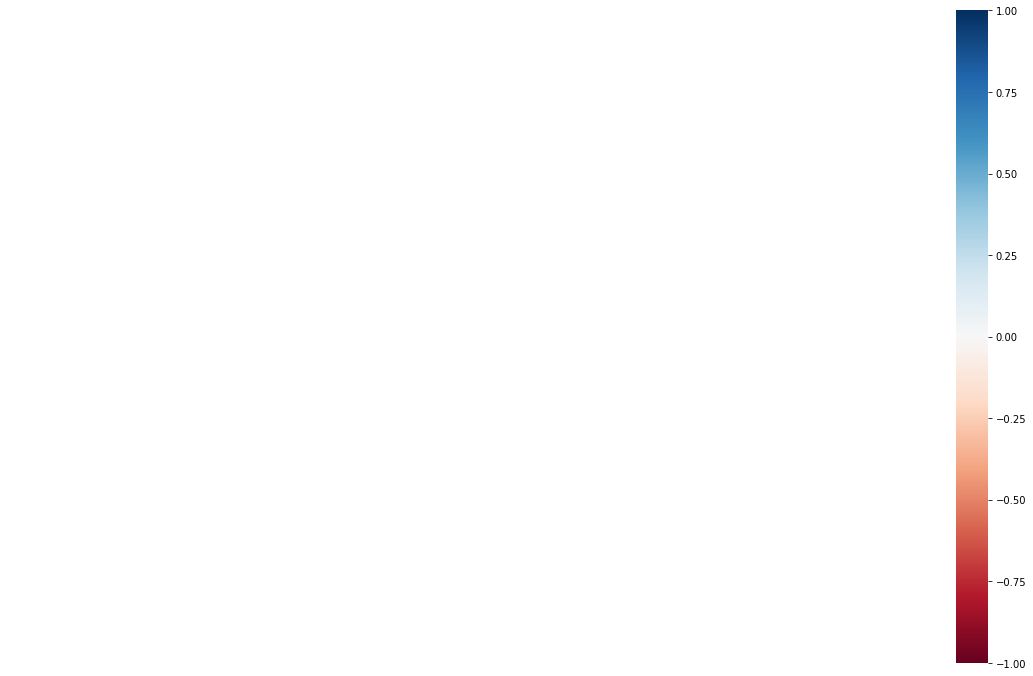

In [30]:
mn.heatmap(users)

/usr/local/lib/python3.7/dist-packages/seaborn/matrix.py:305: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
/usr/local/lib/python3.7/dist-packages/seaborn/matrix.py:305: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


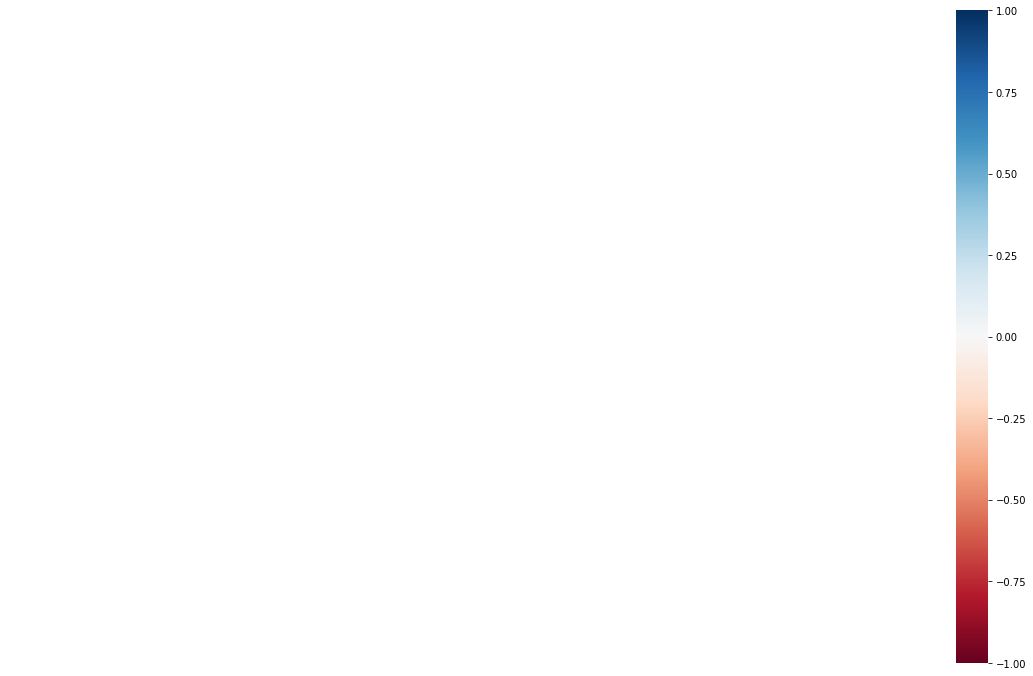

In [31]:
mn.heatmap(movies)

# We have noticed correlated missing values in ratings

In [33]:
# preparing the training set and test set
training_set = pd.read_csv('/content/u1.base', delimiter = '\t')
training_set = np.array(training_set, dtype = 'int')
test_set = pd.read_csv('/content/u1.test', delimiter = '\t')
test_set = np.array(test_set, dtype = 'int')

In [34]:

# Getting the number of users and movies
nb_users = int(max(max(training_set[:,0]), max(test_set[:,0])))
nb_movies = int(max(max(training_set[:,1]), max(test_set[:,1])))

In [35]:
# converting the data into array with users in lines and movies in column
def convert(data):
    new_data = []
    for id_users in range(1, nb_users+1):
        id_movies = data[:,1][data[:,0] == id_users]
        id_ratings = data[:,2][data[:,0] == id_users]
        ratings = np.zeros(nb_movies)
        ratings[id_movies - 1] = id_ratings
        new_data.append(list(ratings))
    return new_data
training_set = convert(training_set)
test_set = convert(test_set)

In [36]:
# converting the data into torch tensor
training_set = torch.FloatTensor(training_set)
test_set = torch.FloatTensor(test_set)

# Restricted Boltzman Machine

In [37]:
training_set[training_set == 0] = -1
training_set[training_set == 1] = 0
training_set[training_set == 2] = 0
training_set[training_set >=3 ] = 1
test_set[test_set == 0] = -1
test_set[test_set == 1] = 0
test_set[test_set == 2] = 0
test_set[test_set >=3 ] = 1

In [58]:
# Creating the architecture of the Neural Network
class RBM():
    def __init__(self, nv, nh):
        self.W = torch.randn(nh, nv)
        self.a = torch.randn(1, nh)
        self.b = torch.randn(1, nv)
    def sample_h(self, x):
        wx = torch.mm(x, self.W.t())
        activation = wx + self.a.expand_as(wx)
        p_h_given_v = torch.sigmoid(activation)
        return p_h_given_v, torch.bernoulli(p_h_given_v)
    def sample_v(self, y):
        wy = torch.mm(y, self.W)
        activation = wy + self.b.expand_as(wy)
        p_v_given_h = torch.sigmoid(activation)
        return p_v_given_h, torch.bernoulli(p_v_given_h)
    def train(self, v0, vk, ph0, phk):
        self.W += torch.mm(v0.t(), ph0) - torch.mm(vk.t(), phk)
        self.b += torch.sum((v0 - vk), 0)
        self.a += torch.sum((ph0 - phk), 0)
nv = len(training_set[0])
nh = 100
batch_size = 100
rbm = RBM(nv, nh)

In [61]:
# Did not Train the RBM model due to error in processing data 
nb_epoch = 10
for epoch in range(1, nb_epoch + 1):
    train_loss = 0
    s = 0.
    for id_user in range(0, nb_users - batch_size, batch_size):
        vk = training_set[id_user:id_user+batch_size]
        v0 = training_set[id_user:id_user+batch_size]
        ph0,_ = rbm.sample_h(v0)
        phk,_ = rbm.sample_h(vk)
        #rbm.train(v0, vk, ph0, phk)
        train_loss += torch.mean(torch.abs(v0[v0>=0] - vk[v0>=0]))
        s += 1.
    print('epoch: '+str(epoch)+' loss: '+str(train_loss/s))

epoch: 1 loss: tensor(0.)
epoch: 2 loss: tensor(0.)
epoch: 3 loss: tensor(0.)
epoch: 4 loss: tensor(0.)
epoch: 5 loss: tensor(0.)
epoch: 6 loss: tensor(0.)
epoch: 7 loss: tensor(0.)
epoch: 8 loss: tensor(0.)
epoch: 9 loss: tensor(0.)
epoch: 10 loss: tensor(0.)


In [60]:
# Testing the RBM Model
test_loss = 0
s = 0.
for id_user in range(nb_users):
    v = training_set[id_user:id_user+1]
    vt = test_set[id_user:id_user+1]
    if len(vt[vt>=0]) > 0:
        _,h = rbm.sample_h(v)
        _,v = rbm.sample_v(h)
        test_loss += torch.mean(torch.abs(vt[vt>=0] - v[vt>=0]))
        s += 1.
print('test loss: '+str(test_loss/s))

test loss: tensor(0.5779)


# Sources used:
- https://towardsdatascience.com/most-effective-way-to-implement-radial-basis-function-neural-network-for-classification-problem-33c467803319

- https://pyimagesearch.com/2014/06/23/applying-deep-learning-rbm-mnist-using-python/

- https://github.com/AmirAli5/Deep-Learning/blob/master/2.Unsupervised%20Deep%20Learning/5.Restricted%20Boltzman%20Machine/Recommendation%20System%20for%20Movies.ipynb